<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_2_SkimLit_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2.2: SkimLit Full

Esta é a continuidade do projeto SkimLit+.

Neste projeto a base de dados PubMed 200k RCT completa é utilizada.

* `pubmed-rct/PubMed_200k_RCT/train.txt`
* `pubmed-rct/PubMed_200k_RCT/test.txt`

# Importações

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, Input, LSTM, TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Configurações e constantes

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEMENTE = 2008193

COR = '#007f66'

DIRETORIO = '/content/pubmed-rct/PubMed_200k_RCT'

LIMITE_DICIONARIO = 331000
LIMITE_CARACTERES = 80

LIMITE_INCORPORADOR = 256
LIMITE_INCORPORADOR_CARACTERES = 32

LOTE_TAMANHO = 64

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

SUAVIZACAO = 0.1
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 3

# Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-02-08 23:00:20--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7753 (7.6K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-02-08 23:00:20 (67.3 MB/s) - ‘funcoes.py’ saved [7753/7753]



In [4]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao, preprocessar_texto

# Dados

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

!7z e -o$DIRETORIO $DIRETORIO/train.7z

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.71 MiB/s, done.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/pubmed-rct/PubMed_200k_RCT/                                              1 file, 66928396 bytes (64 MiB)

Extracting archive: /content/pubmed-rct/PubMed_200k_RCT/train.7z
--
Path = /content/pubmed-rct/PubMed_200k_RCT/train.7z
Type = 7z
Physical Size = 66928396
Headers Size = 121
Method = LZMA:26
Solid = -
Blocks = 1

  0%      4% - train.txt     

In [6]:
df_treino = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/train.txt'))
df_teste  = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/test.txt'))

# 30% dos dados de treino. Restrição para possibilitar execução no Colab.
np.random.seed(SEMENTE)
df_treino = df_treino.sample(frac=0.3, random_state=SEMENTE)

codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_teste  = codificador_onehot.transform(df_teste['classe'].to_numpy().reshape(-1, 1))

codificador_int = LabelEncoder()

rotulos_int_treino = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_teste  = codificador_int.transform(df_teste['classe'].to_numpy())

classes = codificador_int.classes_

palavras_por_texto_98   = int(np.percentile([len(texto.split()) for texto in df_treino['texto']], 98))
caracteres_por_texto_98 = int(np.percentile([len(texto) for texto in df_treino['texto']], 98))

lista_caracteres_treino = [" ".join(list(texto)) for texto in df_treino['texto']]
lista_caracteres_teste  = [" ".join(list(texto)) for texto in df_teste['texto']]

numero_linha_98 = int(np.percentile(df_treino['numero'], 98))

linhas_numero_onehot_treino = tf.one_hot(df_treino['numero'], depth=numero_linha_98)
linhas_numero_onehot_teste  = tf.one_hot(df_teste['numero'], depth=numero_linha_98)

total_linhas_98 = int(np.percentile(df_treino['total'], 98))

linhas_total_onehot_treino = tf.one_hot(df_treino['total'], depth=total_linhas_98)
linhas_total_onehot_teste  = tf.one_hot(df_teste['total'], depth=total_linhas_98)

dados_hibridos_linhas_treino_textos  = Dataset.from_tensor_slices((df_treino['texto'], lista_caracteres_treino, linhas_numero_onehot_treino, linhas_total_onehot_treino))
dados_hibridos_linhas_treino_rotulos = Dataset.from_tensor_slices(rotulos_onehot_treino)
dados_hibridos_linhas_treino         = Dataset.zip((dados_hibridos_linhas_treino_textos, dados_hibridos_linhas_treino_rotulos))
dados_hibridos_linhas_treino         = dados_hibridos_linhas_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

dados_hibridos_linhas_teste_textos  = Dataset.from_tensor_slices((df_teste['texto'], lista_caracteres_teste, linhas_numero_onehot_teste, linhas_total_onehot_teste))
dados_hibridos_linhas_teste_rotulos = Dataset.from_tensor_slices(rotulos_onehot_teste)
dados_hibridos_linhas_teste         = Dataset.zip((dados_hibridos_linhas_teste_textos, dados_hibridos_linhas_teste_rotulos))
dados_hibridos_linhas_teste         = dados_hibridos_linhas_teste.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Camadas auxiliares

In [7]:
vetorizador_palavras = TextVectorization(max_tokens=LIMITE_DICIONARIO,
                                         output_mode='int',
                                         output_sequence_length=palavras_por_texto_98,
                                         name='vetorizador_palavras')

vetorizador_palavras.adapt(df_treino['texto'])

vocabulario_palavras = vetorizador_palavras.get_vocabulary()

incorporador_palavras = Embedding(input_dim=len(vocabulario_palavras),
                                  output_dim=LIMITE_INCORPORADOR,
                                  mask_zero=True,
                                  input_length=palavras_por_texto_98,
                                  name='incorporador_palavras')

vetorizador_caracteres = TextVectorization(max_tokens=LIMITE_CARACTERES,
                                           output_mode='int',
                                           output_sequence_length=caracteres_por_texto_98,
                                           name='vetorizador_caracteres')

vetorizador_caracteres.adapt(lista_caracteres_treino)

vocabulario_caracteres = vetorizador_caracteres.get_vocabulary()

incorporador_caracteres = Embedding(input_dim=len(vocabulario_caracteres),
                                    output_dim=LIMITE_INCORPORADOR_CARACTERES,
                                    mask_zero=True,
                                    input_length=caracteres_por_texto_98,
                                    name='incorporador_caracteres')

# Modelo

In [8]:
modelo_nome = 'modelo_incorporacao_palavras'


entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

camadas = vetorizador_palavras(entradas)
camadas = incorporador_palavras(camadas)

saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR, activation=ATIVACAO_RNN), name='camada_bi_lstm_palavras')(camadas)

modelo_incorporacao_palavras = Model(inputs=entradas, outputs=saidas, name=modelo_nome)


modelo_nome = 'modelo_incorporacao_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_caracteres')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR_CARACTERES, activation=ATIVACAO_RNN), name='camada_bi_lstm_caracteres')(camadas)

modelo_incorporacao_caracteres = Model(inputs=entradas, outputs=saidas, name=modelo_nome)


combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras.output,
                                                                              modelo_incorporacao_caracteres.output])

abandonos_incorporacao = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)


modelo_nome = 'modelo_numero_linhas'

entradas = Input(shape=(numero_linha_98,), dtype=linhas_numero_onehot_treino.dtype, name='camada_entrada_numero_linhas')

saidas = Dense(numero_linha_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_numero_linhas')(entradas)

modelo_numero_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)


modelo_nome = 'modelo_total_linhas'

entradas = Input(shape=(total_linhas_98,), dtype=linhas_total_onehot_treino.dtype, name='camada_entrada_total_linhas')

saidas = Dense(total_linhas_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_total_linhas')(entradas)

modelo_total_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)


combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

abandonos_linhas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)


modelo_nome = 'modelo_pubmed_200k_rct'

modelo = Model(inputs=[modelo_incorporacao_palavras.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=SGD(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [9]:
modelo.summary()

Model: "modelo_pubmed_200k_rct"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_palavras (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 vetorizador_palavras (TextVect  (None, 67)          0           ['camada_entrada_palavras[0][0]']
 orization)                                                                  

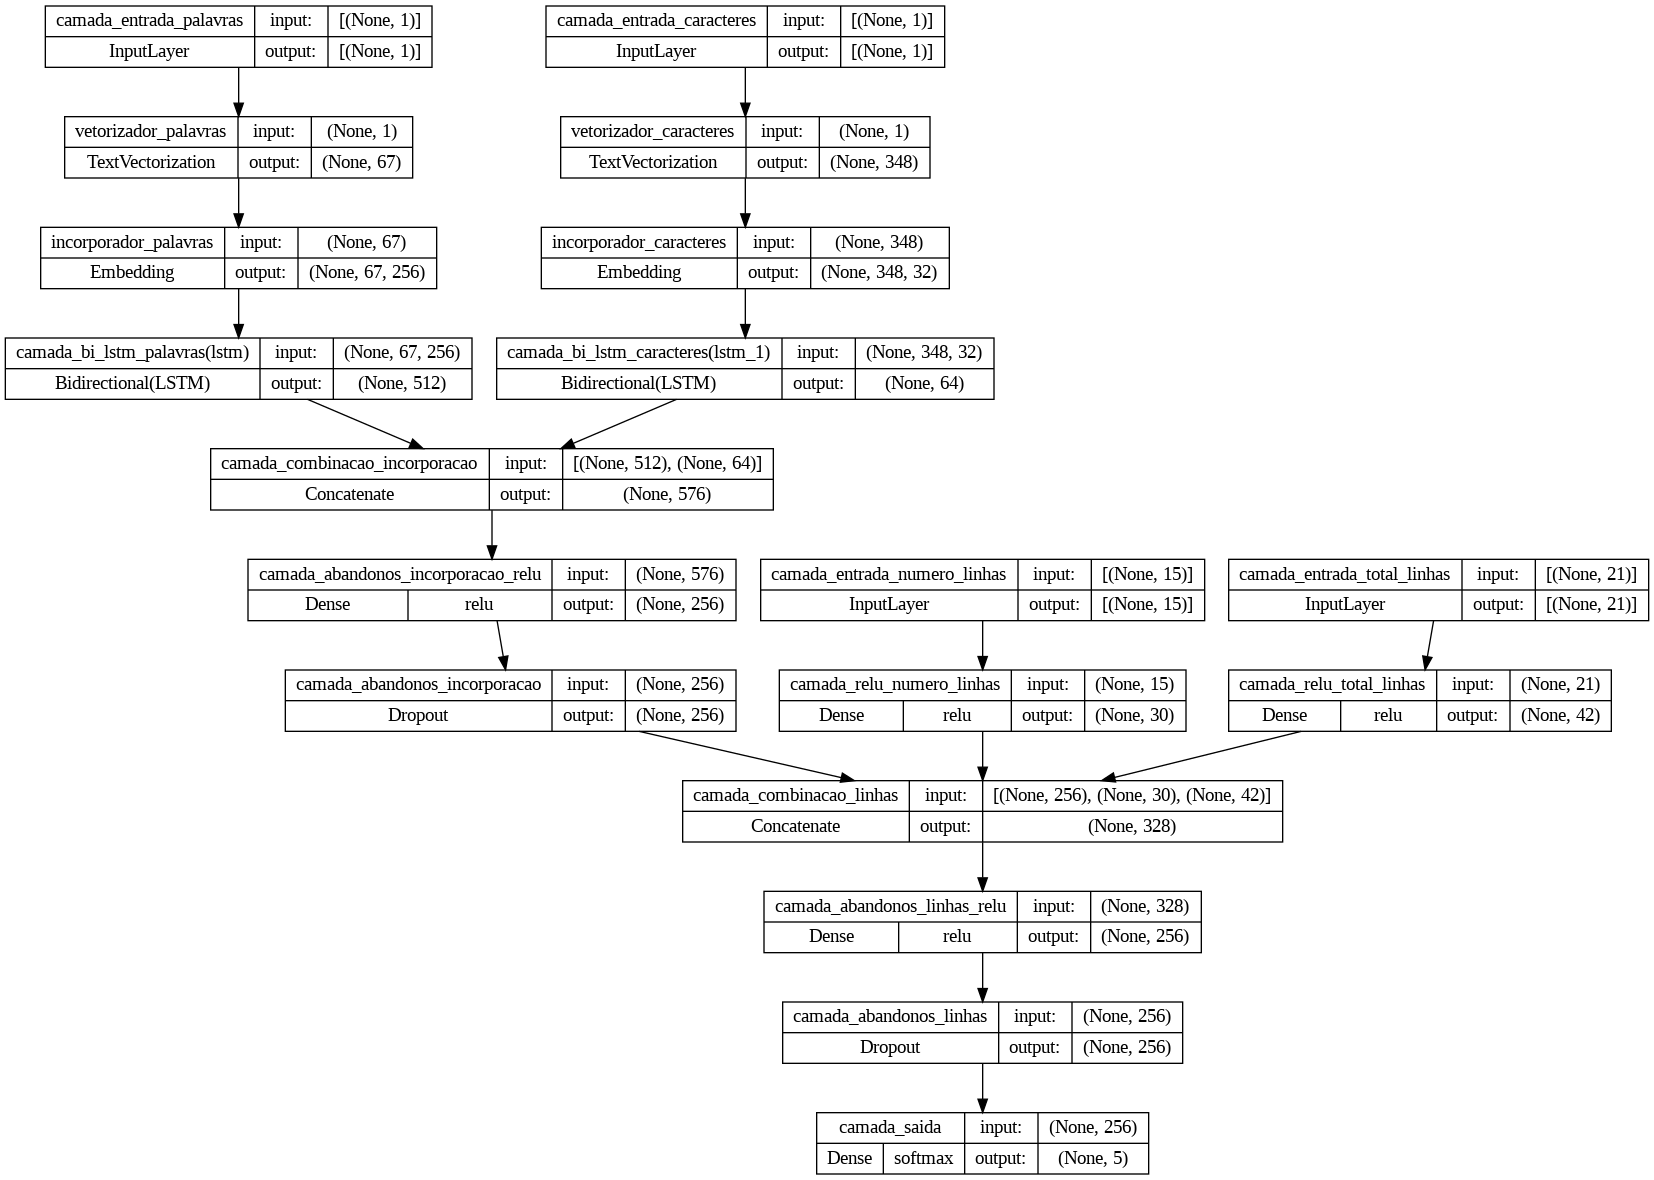

In [10]:
plot_model(modelo, show_shapes=True, show_layer_activations=True)

## Finalização do modelo

In [11]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_teste,
                       verbose=1)

Epoch 1/3
10369/10369 [==============================] - 613s 57ms/step - loss: 1.4391 - accuracy: 0.4322 - val_loss: 1.3285 - val_accuracy: 0.5312
Epoch 2/3
10369/10369 [==============================] - 586s 57ms/step - loss: 1.2288 - accuracy: 0.5537 - val_loss: 1.1164 - val_accuracy: 0.5945
Epoch 3/3
10369/10369 [==============================] - 588s 57ms/step - loss: 1.1000 - accuracy: 0.5863 - val_loss: 1.0555 - val_accuracy: 0.6238


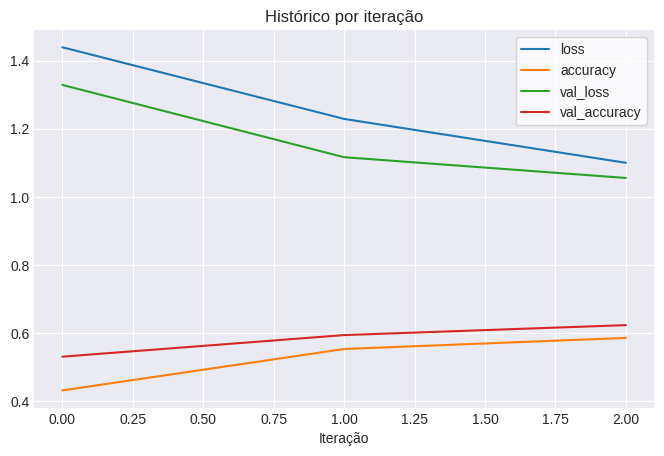

In [12]:
grafico_historico_por_iteracao(historico)

461/461 [==============================] - 16s 24ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.00      0.00      0.00      2663
 CONCLUSIONS       0.74      0.24      0.37      4426
     METHODS       0.65      0.77      0.71      9751
   OBJECTIVE       0.57      0.60      0.58      2377
     RESULTS       0.60      0.81      0.69     10276

    accuracy                           0.62     29493
   macro avg       0.51      0.49      0.47     29493
weighted avg       0.58      0.62      0.58     29493



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

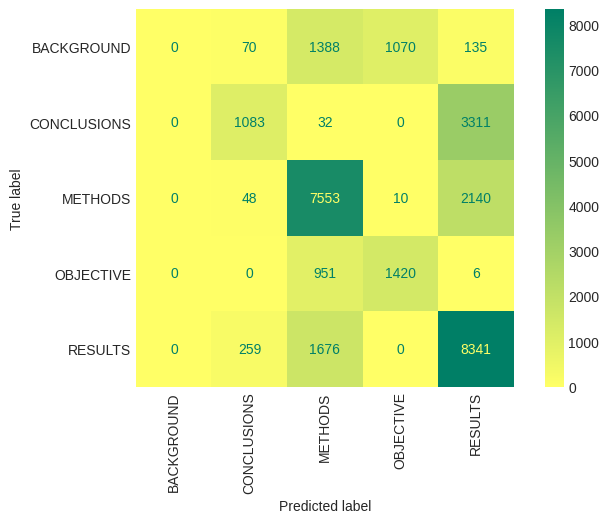

In [13]:
probabilidades = modelo.predict(dados_hibridos_linhas_teste)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes     = avaliar_modelo(rotulos_int_teste, previsoes, classes)

In [14]:
avaliacoes

{'acuracia': 0.6237751330824264,
 'precisao': 0.5809537926302357,
 'revocacao': 0.6237751330824264,
 'pontuacao-f1': 0.5761652059697656}

## Salvar modelo

In [15]:
modelo.save(modelo_nome)